In [37]:
import csv
import json
from copy import deepcopy
import ast
csv.field_size_limit(1131072)

1131072

In [2]:
# Collect All Correction Annotations
coe_annotations = []
for split_name in ["batch_0", "batch_1", "batch_2","batch_3","batch_4","batch_5","batch_6","batch_7"]:
    with open('data/zh_test/annotations/'+split_name+'.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for item in reader:
            coe_annotations.append(item)

In [3]:
print(coe_annotations[0]['WorkTimeInSeconds'])
all_times = []
for i in range(len(coe_annotations)):
    seconds = int(coe_annotations[i]['WorkTimeInSeconds'])
    if seconds>20:
        continue
    all_times.append(seconds)

10


In [4]:
from matplotlib import pylab as plt

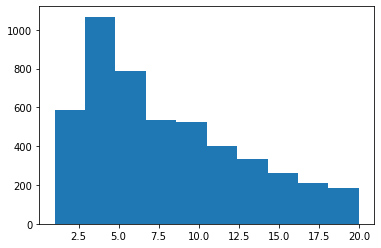

In [5]:
plt.hist(all_times)
plt.show()

In [6]:
print(sum(all_times)/len(all_times))

7.85002043318349


In [7]:
correction_inputs_ids = []
with open('data/zh_test/source/to_tasa_all_zh_trial.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for item in reader:
        correction_inputs_ids.append(item)

In [8]:
# Collect Source Data in English
all_en_data = {}
with open('data/zh_test/source/all_coref_data_en_finalized.json', 'r') as f:
    temp = json.load(f)
    for item in temp:
        all_en_data[item['scene_id']] = item

en_mention_dict = {}
for item in all_en_data:
    annotations = all_en_data[item]['annotations']
    for anno in annotations:
        query = anno['query']
        antecedents = anno['antecedents']
        en_mention_dict[query['mention_id']] = [query['sentenceIndex'], query['startToken'],query['endToken']]
        if antecedents!=[]:
            if isinstance(antecedents[0], dict):
                for ante in antecedents:
                    en_mention_dict[ante['mention_id']] = [ante['sentenceIndex'], ante['startToken'],ante['endToken']]

In [9]:
# Collect Source Data in Chinese
all_zh_data = {}
with open('data/zh_test/source/all_coref_data_en_zh_finalized.json', 'r') as f:
    temp = json.load(f)
    for item in temp:
        all_zh_data[item['scene_id']] = item

zh_mention_dict = {}
for item in all_zh_data:
    annotations = all_zh_data[item]['annotations']
    for anno in annotations:
        query = anno['query']
        antecedents = anno['antecedents']
        zh_mention_dict[query['mention_id']] = [query['sentenceIndex'], query['startToken'],query['endToken']]
        if antecedents!=[]:
            if isinstance(antecedents[0], dict):
                for ante in antecedents:
                    zh_mention_dict[ante['mention_id']] = [ante['sentenceIndex'], ante['startToken'],ante['endToken']]

In [10]:
# Collect Source Data in Chinese
all_zh_data_char = {}
with open('data/zh_test/source/all_coref_data_en_zh_finalized_char.json', 'r') as f:
    temp = json.load(f)
    for item in temp:
        all_zh_data_char[item['scene_id']] = item

In [11]:
def remove_drop_words(alignment):
    result = set()
    for start, end in alignment:
        result.add((start, end//2))
    return result

def extract_pair(result):
    starts = set()
    ends = set()
    for start, end in result:
        starts.add(start)
        ends.add(end)
    start_idx = min(list(starts))
    end_idx = max(list(ends))
    return [min(list(ends)), max(list(ends))+1]

def extract_alignment_pair_original(alignment):
    result = set()
    for s in range(len(alignment)):
        for t in range(len(alignment[0])):
            if alignment[s][t]:
                result.add((s, t))
    return sorted(list(result))

def extract_alignment_pair_space(alignment):
    result = set()
    for s in range(len(alignment)):
        for t in range(len(alignment[0])):
            if alignment[s][t]:
                result.add((s, t))
    return sorted(list(remove_drop_words(result)))

In [81]:
"""
Original Analysis: Remove Drop_Pro
"""
correction_dict = {}
remove_set = set()
add_dict = {}

num_corrected = 0
num_add = 0
num_delete = 0
num_modify = 0

drop_add_num = 0
drop_delete_num = 0
drop_modify_num = 0

add_pronoun_count = 0

target_string_set = set()
for i in range(len(coe_annotations)):
    # ZH Side Numbers
    zh_original_result = extract_alignment_pair_space(json.loads(coe_annotations[i]['Input.config_obj'])['alignment'])
    zh_corrected_result = extract_alignment_pair_space(json.loads(coe_annotations[i]['Answer.alignment']))

    zh_original_result_with_drop = extract_alignment_pair_original(json.loads(coe_annotations[i]['Input.config_obj'])['alignment'])
    zh_corrected_result_with_drop = extract_alignment_pair_original(json.loads(coe_annotations[i]['Answer.alignment']))

    if zh_original_result==zh_corrected_result:
        continue
    mention_id = correction_inputs_ids[i]['mention_id']
    num_corrected += 1
    # Build char_to_word idx map
    sent_id = en_mention_dict[mention_id][0]
    sent_char = all_zh_data_char[mention_id[:10]]['sentences'][sent_id]
    sent_word = all_zh_data[mention_id[:10]]['sentences'][sent_id]
    map_char_word = {}
    count = 0
    for idx_w, word in enumerate(sent_word):
        for char in word:
            map_char_word[count] = idx_w
            count += 1
    # Extract Mention start_end and convert from char level to word level
    a = ()
    b = ()

    if zh_original_result:
        a_temp = extract_pair(zh_original_result)
        if a_temp:
            a = (map_char_word[a_temp[0]], map_char_word[a_temp[1] - 1] + 1)
    if zh_corrected_result:
        b_temp = extract_pair(zh_corrected_result)
        b = (map_char_word[b_temp[0]], map_char_word[b_temp[1] - 1] + 1)


    input_tokens = ast.literal_eval(coe_annotations[i]['Input.src_tokens'])
    target_tokens = ast.literal_eval(coe_annotations[i]['Input.tar_tokens'])
    original_target_mention_str = " ".join([target_tokens[item[1]] for item in zh_original_result_with_drop])
    original_source_mention_str = " ".join([input_tokens[item[0]] for item in zh_original_result_with_drop])
    corrected_target_mention_str = " ".join([target_tokens[item[1]] for item in zh_corrected_result_with_drop])

    # Count Correction Statistics

    if a==() and b!=():
        num_add += 1
        # print(input_tokens)
        # print(target_tokens)
        # print(zh_original_result_with_drop, [(input_tokens[item[0]], target_tokens[item[1]]) for item in zh_original_result_with_drop])
        # print(zh_corrected_result_with_drop, [(input_tokens[item[0]], target_tokens[item[1]]) for item in zh_corrected_result_with_drop])

        if set(["你", "我", "他", "她", "它", "谁", "们", "的", "这", "那", "什么"]) & set([target_tokens[item[1]] for item in zh_corrected_result_with_drop]):
            add_pronoun_count += 1
        elif corrected_target_mention_str=="":
            drop_add_num += 1
        else:
            pass

        target_string_set.add(corrected_target_mention_str)
    if a!=() and b==():
        num_delete += 1
        # print(input_tokens)
        # print(target_tokens)
        # print(zh_original_result_with_drop, [(input_tokens[item[0]], target_tokens[item[1]]) for item in zh_original_result_with_drop])
        # print(zh_corrected_result_with_drop, [(input_tokens[item[0]], target_tokens[item[1]]) for item in zh_corrected_result_with_drop])
        # print(original_source_mention_str)
        # print("=="*50)
        if corrected_target_mention_str=="":
            drop_delete_num += 1
            # print(zh_corrected_result)
            # print(zh_corrected_result_with_drop)
            # print()
    if a!=() and b!=():
        num_modify += 1
        # print(input_tokens)
        # print(target_tokens)
        # print(zh_original_result_with_drop, [(input_tokens[item[0]], target_tokens[item[1]]) for item in zh_original_result_with_drop])
        # print(zh_corrected_result_with_drop, [(input_tokens[item[0]], target_tokens[item[1]]) for item in zh_corrected_result_with_drop])
        print(original_target_mention_str)
        print(corrected_target_mention_str)
        print("=="*50)
        if corrected_target_mention_str=="":
            drop_modify_num += 1
    if b==(): # Add mention_id to remove set
        remove_set.add(mention_id)
    elif a==(): # Collect mentions to add
        add_dict[mention_id] = [sent_id, b[0], b[1]]
    else:
        correction_dict[mention_id] = [sent_id, b[0], b[1]]

开  玩  笑
玩  笑
看  电  视
电  视
柜  子  缝  里
缝
我  会
我
那  么  不  好  过
不  好  过
失  血  太  多
失  血
他
他  的
有  事

当  时  就  是  一  时  冲  动
一  时  冲  动
那  种

也
我
那

机  器  简  直  棒  极  了
机  器
我
我  的
十  十  二  个  月
十  二  个  月
对

子  宫
 子  宫
容  易  的  办  法  把  它  弄
容  易  的  办  法  把  它  弄  下  来
不  过  就  是  个  物  理  学  问  题
个  物  理  学  问  题
一  根  足  够  长  的  的  杠  杆
杠  杆
原  材  料  把  这  个  杠  杆  做
原  材  料
这  个  杠  杆  做
杠  杆
我  敢
我
这  附  近  有  东  西  能  当  这  个  "  撬  棍
东  西
"  撬  棍
撬  棍
解  决  问  题
问  题
顺  序  一  个  个
按  顺  序  一  个  个
我  们  按  顺  序  一  个  个  解  决  问  题  首  先  我  们
我  们
姐  妹
姐  妹  们
打  电  话
电  话
我
我  的
泥  地  里
泥  地
我
我  的
家  庭  里  的  一  员  好
家  庭  里  的  一  员
耳  洞
 耳
我  们  一  定  可  以  找  到  别  的  办  法
别  的  办  法
光  束  太  粗
光  束 
脾  气  那  么
脾  气
联  盟  里  的  人  来
联  盟  里  的  人
联  盟
复  仇  者  联  盟
你
你  的
街  上
街
长  大  成  人
成  人
脸  上
脸
有  个  一  米  八  的  穿  着  闪  电  侠  T  恤  的  汉  子
一  米  八  的  穿  着  闪  电  侠  T  恤  的  汉  子
个  告  别  单  身  趴  别
告  别  单  身  趴
什  么
什  么  东  西
你  在  麻  省  理  工
你  在  麻  省  理  工  的  学

In [82]:
print(add_pronoun_count, drop_add_num, drop_modify_num)

191 340 61


In [ ]:
["你", "我", "他", "她", "它", "谁", "们"]

In [62]:
print(set(["你", "我", "他", "她", "它", "谁", "们", "的", "这", "那", "什么"]) & set(['你', "", "是谁接电话"]))

{'你'}


In [32]:
print(drop_add_num, drop_add_num/len(coe_annotations)*100)
print(drop_delete_num, drop_add_num/len(coe_annotations)*100)
print(drop_modify_num, drop_add_num/len(coe_annotations)*100)

print(num_add, num_add/len(coe_annotations)*100)
print(num_delete, num_delete/len(coe_annotations)*100)
print(num_modify, num_modify/len(coe_annotations)*100)
print(num_corrected, num_corrected/len(coe_annotations)*100)

340 4.432277408421327
0 4.432277408421327
61 4.432277408421327
609 7.938991005084082
440 5.735888410898188
918 11.967149002737584
1967 25.642028418719853


In [ ]:
"""
Keep Drop_Pro Words
"""
correction_dict = {}
remove_set = set()
add_dict = {}

num_corrected = 0
num_add = 0
num_delete = 0
num_modify = 0

for i in range(len(coe_annotations)):
    # ZH Side Numbers
    zh_original_result = extract_alignment_pair_space(json.loads(coe_annotations[i]['Input.config_obj'])['alignment'])
    zh_corrected_result = extract_alignment_pair_space(json.loads(coe_annotations[i]['Answer.alignment']))
    if zh_original_result==zh_corrected_result:
        continue
    mention_id = correction_inputs_ids[i]['mention_id']
    num_corrected += 1
    # Build char_to_word idx map
    sent_id = en_mention_dict[mention_id][0]
    sent_char = all_zh_data_char[mention_id[:10]]['sentences'][sent_id]
    sent_word = all_zh_data[mention_id[:10]]['sentences'][sent_id]
    map_char_word = {}
    count = 0
    for idx_w, word in enumerate(sent_word):
        for char in word:
            map_char_word[count] = idx_w
            count += 1
    # Extract Mention start_end and convert from char level to word level
    a = ()
    b = ()

    if zh_original_result:
        a_temp = extract_pair(zh_original_result)
        if a_temp:
            a = (map_char_word[a_temp[0]], map_char_word[a_temp[1] - 1] + 1)
    if zh_corrected_result:
        b_temp = extract_pair(zh_corrected_result)
        b = (map_char_word[b_temp[0]], map_char_word[b_temp[1] - 1] + 1)

    # Count Correction Statistics
    # print(a, b)
    if a==() and b!=():
        print(a, b)
        print(zh_corrected_result)
        print()
        num_add += 1
    if a!=() and b==():
        num_delete += 1
    if a!=() and b!=():
        num_modify += 1

    if b==(): # Add mention_id to remove set
        remove_set.add(mention_id)
    elif a==(): # Collect mentions to add
        add_dict[mention_id] = [sent_id, b[0], b[1]]
    else:
        correction_dict[mention_id] = [sent_id, b[0], b[1]]

In [22]:
print(num_add, num_add/len(coe_annotations)*100)
print(num_delete, num_delete/len(coe_annotations)*100)
print(num_modify, num_modify/len(coe_annotations)*100)
print(num_corrected, num_corrected/len(coe_annotations)*100)

609 7.938991005084082
440 5.735888410898188
918 11.967149002737584
1967 25.642028418719853


In [22]:
print(num_corrected, len(coe_annotations))

1967 7671


In [9]:
print(1967/7671)

0.25642028418719853


In [9]:
import pickle as pkl

scene_ids = set()
for item in correction_dict:
    scene_ids.add(item[:10])
for item in remove_set:
    scene_ids.add(item[:10])
for item in add_dict:
    scene_ids.add(item[:10])

all_results = {}
for item in scene_ids:
    all_results[item] = {
        "correction_dict": {},
        "remove_set": set(),
        "add_dict": {}
    }

for item in remove_set:
    all_results[item[:10]]['remove_set'].add(item)
for item in correction_dict:
    all_results[item[:10]]['correction_dict'][item] = correction_dict[item]
for item in add_dict:
    all_results[item[:10]]['add_dict'][item] = add_dict[item]

with open('data/zh/all_correction_results.pkl', 'wb') as f:
    pkl.dump(all_results, f)

In [10]:
print(all_results)

{'s09e16c01t': {'correction_dict': {'s09e16c01t|13': [0, 1, 3], 's09e16c01t|21': [2, 11, 13], 's09e16c01t|30': [2, 3, 5], 's09e16c01t|39': [3, 4, 7], 's09e16c01t|66': [9, 6, 7], 's09e16c01t|80': [16, 1, 2], 's09e16c01t|82': [16, 6, 7], 's09e16c01t|85': [16, 12, 13], 's09e16c01t|100': [16, 11, 13], 's09e16c01t|103': [16, 22, 25], 's09e16c01t|110': [17, 2, 4]}, 'remove_set': set(), 'add_dict': {'s09e16c01t|4': [0, 1, 4], 's09e16c01t|5': [0, 2, 3], 's09e16c01t|9': [0, 1, 2]}}, 's09e07c03t': {'correction_dict': {'s09e07c03t|0': [0, 0, 3], 's09e07c03t|3': [1, 0, 24], 's09e07c03t|6': [1, 1, 3], 's09e07c03t|12': [1, 16, 18], 's09e07c03t|28': [5, 4, 5]}, 'remove_set': set(), 'add_dict': {'s09e07c03t|4': [1, 1, 2], 's09e07c03t|26': [4, 5, 6], 's09e07c03t|42': [9, 0, 1], 's09e07c03t|55': [11, 3, 4], 's09e07c03t|69': [12, 0, 1]}}, 's09e10c04t': {'correction_dict': {'s09e10c04t|15': [3, 1, 2], 's09e10c04t|16': [3, 1, 3], 's09e10c04t|22': [3, 16, 17], 's09e10c04t|28': [4, 7, 17], 's09e10c04t|37': [

In [12]:
print(39.23-37.18)
print(39.54-37.01)
print(50.58-47.20)

2.049999999999997
2.530000000000001
3.3799999999999955
